In [1]:
pip install pandas openpyxl matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

# Carga de los archivos Excel
compras = pd.read_excel(r"C:\Users\valer\Desktop\PROYECTO_FINAL_DIPLOMADO\Datos limpios\facturas_compras.xlsx")  
ventas = pd.read_excel(r"C:\Users\valer\Desktop\PROYECTO_FINAL_DIPLOMADO\Datos limpios\ventas_facturacion.xlsx")  

compras.head()


,id_proveedor,nombre_proveedor,numero_factura,fecha,total_compra,descuentos,importe_base,credito_fiscal
0,1020757027,PIL ANDINA S.A.,5949,2022-01-29,1221.17,0.00,1218.91,158.46
1,1023233029,INDUSTRIAS DE ACEITE SA,26237,2022-01-28,3606.56,49.49,3557.07,462.42
2,1006843022,PROMOTORA DE EVENTOS S.A. PROESA,1137,2022-01-28,1465.98,379.23,1086.75,141.28
3,1020229024,CERVECERIA BOLIVIANA NACIONAL S.A.,136487,2022-01-28,2066.01,0.00,1721.28,223.77
4,1020757027,PIL ANDINA S.A.,5682,2022-01-27,1100.32,7.34,1092.98,142.09


In [3]:
ventas.head()

,fecha,num_factura,id_cliente,cliente,total_venta,importe_base,debito_fiscal
0,2022-01-31,3103,0,GONZALO VALVERDE,565.5,565.5,73.52
1,2022-01-31,3102,0,MARCO GUERRA,110.5,110.5,14.37
2,2022-01-31,3101,0,RIVERO,208.5,208.5,27.11
3,2022-01-31,3100,0,DIAZ,68.0,68.0,8.84
4,2022-01-31,3099,0,PEDRO CAMACHO,29.0,29.0,3.77


In [4]:
compras['fecha'] = pd.to_datetime(compras['fecha'])
ventas['fecha'] = pd.to_datetime(ventas['fecha'])


In [5]:
# Verificar valores faltantes
print(compras.isnull().sum())
print(ventas.isnull().sum())

# Rellenar o eliminar valores nulos
compras.fillna(0, inplace=True)  # Opcional: Rellenar con 0
ventas.fillna(0, inplace=True)


id_proveedor        0
nombre_proveedor    0
numero_factura      0
fecha               0
total_compra        0
descuentos          0
importe_base        0
credito_fiscal      0
dtype: int64
fecha            0
num_factura      0
id_cliente       0
cliente          0
total_venta      0
importe_base     0
debito_fiscal    0
dtype: int64


In [6]:
# Agrupar por fecha
compras_agrupadas = compras.groupby('fecha')['total_compra'].sum().reset_index()
ventas_agrupadas = ventas.groupby('fecha')['total_venta'].sum().reset_index()

# Renombrar columnas para evitar confusión
compras_agrupadas.rename(columns={'total_compra': 'total_compras'}, inplace=True)
ventas_agrupadas.rename(columns={'total_venta': 'total_ventas'}, inplace=True)

# Combinar ambas tablas en una sola base de datos
datos_base = compras_agrupadas.merge(ventas_agrupadas, on='fecha', how='outer')
datos_base.fillna(0, inplace=True)  # Rellenar valores faltantes con 0

datos_base.head()


,fecha,total_compras,total_ventas
0,2022-01-03,2518.59,1903.8
1,2022-01-04,4608.90,2959.6
2,2022-01-05,1592.50,2977.7
3,2022-01-06,8863.02,4262.2
4,2022-01-07,2109.60,2575.9


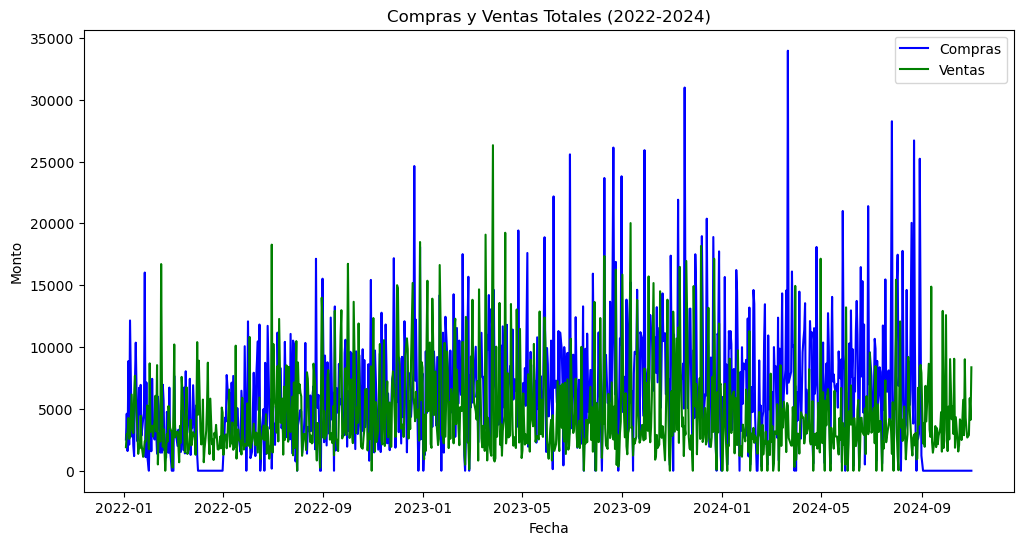

In [7]:
import matplotlib.pyplot as plt

# Gráfica de compras y ventas
plt.figure(figsize=(12, 6))
plt.plot(datos_base['fecha'], datos_base['total_compras'], label='Compras', color='blue')
plt.plot(datos_base['fecha'], datos_base['total_ventas'], label='Ventas', color='green')
plt.title('Compras y Ventas Totales (2022-2024)')
plt.xlabel('Fecha')
plt.ylabel('Monto')
plt.legend()
plt.show()


In [8]:
ruta_excel = r'C:\Users\valer\Desktop\PROYECTO_FINAL_DIPLOMADO\Prueba modelos\Prediccion\compras_ventas_combinadas.xlsx'
datos_base.to_excel(ruta_excel, index=False, sheet_name='Clasificados', engine='openpyxl')

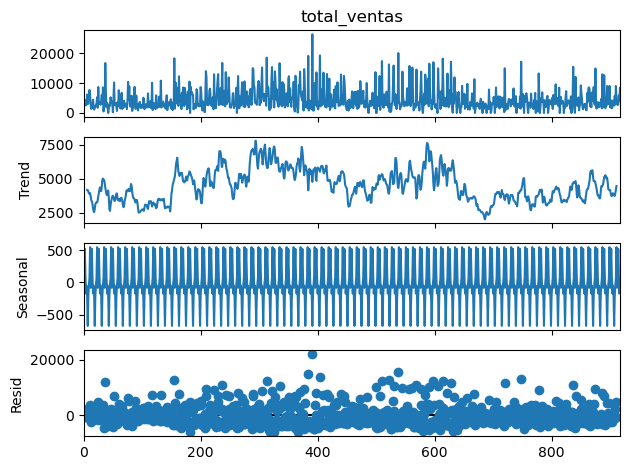

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

descomposicion = seasonal_decompose(datos_base['total_ventas'], model='additive', period=12) 
descomposicion.plot()
plt.show()


In [10]:
from statsmodels.tsa.stattools import adfuller

# Prueba de Dickey-Fuller para la serie de ventas
resultado_adf = adfuller(datos_base['total_ventas'])
print(f'Estadístico ADF: {resultado_adf[0]}')
print(f'p-valor: {resultado_adf[1]}')

Estadístico ADF: -4.193159555953924
p-valor: 0.000676689687955266


La serie es estacionaria.

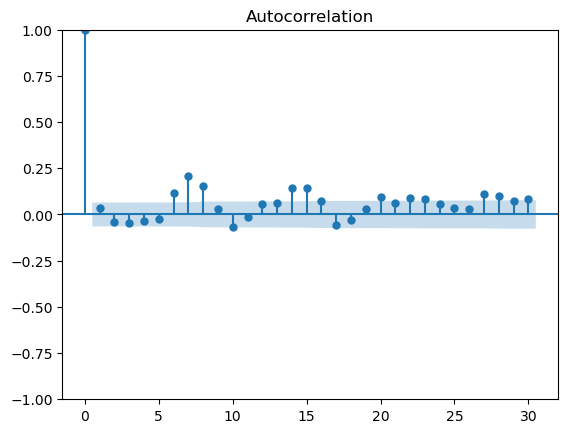

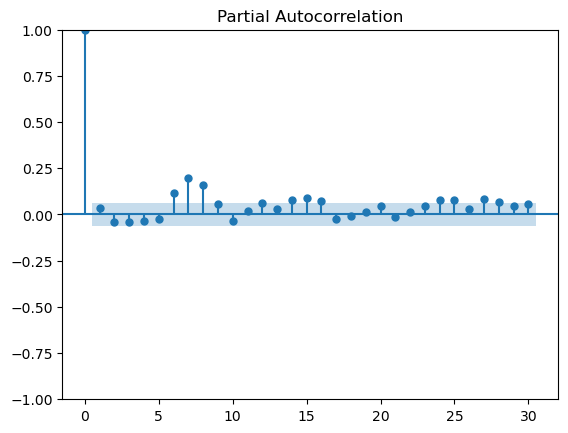

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Gráficas ACF y PACF para la serie diferenciada
plot_acf(datos_base['total_ventas'].dropna(), lags=30)
plot_pacf(datos_base['total_ventas'].dropna(), lags=30)
plt.show()


                               SARIMAX Results                                
Dep. Variable:           total_ventas   No. Observations:                  918
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -8829.447
Date:                Wed, 22 Jan 2025   AIC                          17666.893
Time:                        18:22:38   BIC                          17686.182
Sample:                             0   HQIC                         17674.254
                                - 918                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4507.4408    188.200     23.950      0.000    4138.576    4876.305
ar.L1         -0.3028      0.845     -0.358      0.720      -1.960       1.354
ma.L1          0.3406      0.835      0.408      0.6

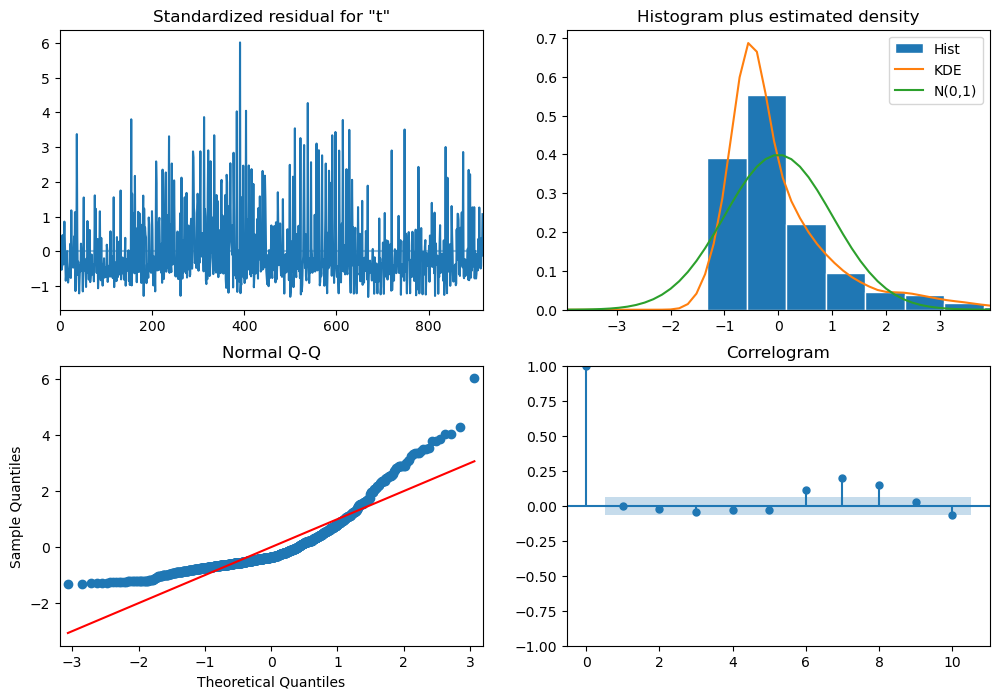

In [12]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Configuración del modelo ARIMA
modelo_arima = ARIMA(datos_base['total_ventas'], order=(1, 0, 1))  
modelo_fit = modelo_arima.fit()

# Resumen del modelo
print(modelo_fit.summary())

# Diagnóstico de residuos
modelo_fit.plot_diagnostics(figsize=(12, 8))
plt.show()


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Obtener los valores ajustados del entrenamiento
valores_ajustados = modelo_fit.fittedvalues
valores_reales = datos_base['total_ventas']

# Calcular MAE y RMSE
mae = mean_absolute_error(valores_reales, valores_ajustados)
rmse = np.sqrt(mean_squared_error(valores_reales, valores_ajustados))

# Imprimir resultados
print(f"MAE (Entrenamiento): {mae}")
print(f"RMSE (Entrenamiento): {rmse}")

MAE (Entrenamiento): 2670.5165764607955
RMSE (Entrenamiento): 3638.0044786001267


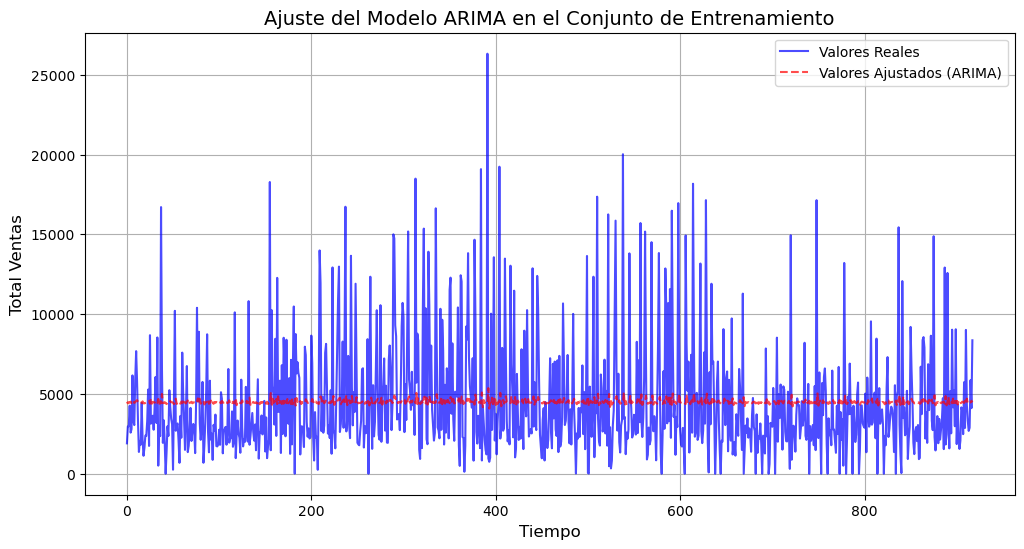

In [14]:
import matplotlib.pyplot as plt

# Graficar los valores reales y ajustados
plt.figure(figsize=(12, 6))
plt.plot(datos_base['total_ventas'], label='Valores Reales', color='blue', alpha=0.7)
plt.plot(modelo_fit.fittedvalues, label='Valores Ajustados (ARIMA)', color='red', linestyle='--', alpha=0.7)
plt.title('Ajuste del Modelo ARIMA en el Conjunto de Entrenamiento', fontsize=14)
plt.xlabel('Tiempo', fontsize=12)
plt.ylabel('Total Ventas', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

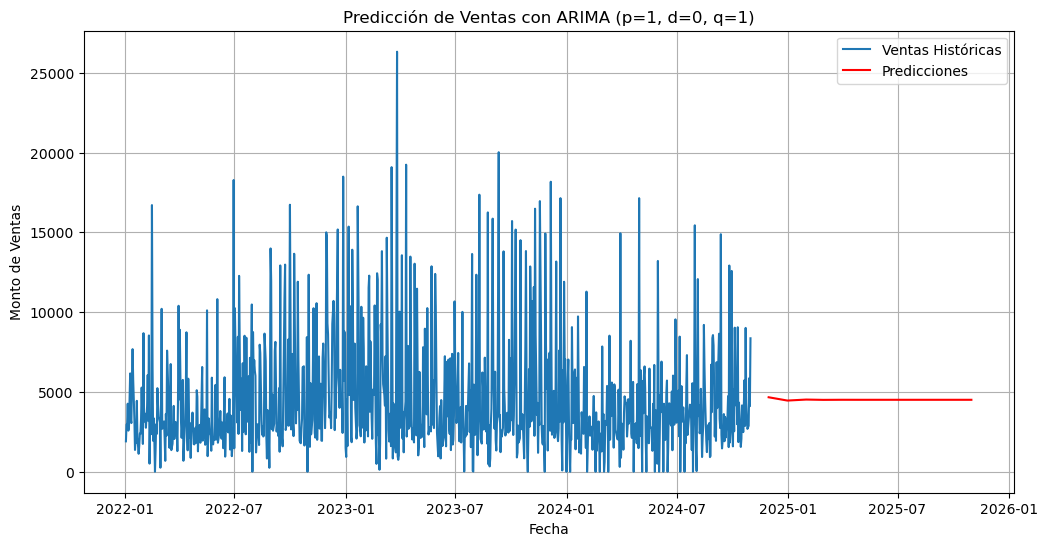

In [15]:
# Predicción para los próximos 12 periodos
predicciones = modelo_fit.forecast(steps=12)

# Crear un rango de fechas para las predicciones
import pandas as pd
futuras_fechas = pd.date_range(start=datos_base['fecha'].iloc[-1], periods=13, freq='ME')[1:]

# Visualizar las predicciones
plt.figure(figsize=(12, 6))
plt.plot(datos_base['fecha'], datos_base['total_ventas'], label='Ventas Históricas')
plt.plot(futuras_fechas, predicciones, label='Predicciones', color='red')
plt.title('Predicción de Ventas con ARIMA (p=1, d=0, q=1)')
plt.xlabel('Fecha')
plt.ylabel('Monto de Ventas')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustar un modelo SARIMA
modelo_sarima = SARIMAX(
    datos_base['total_ventas'],  # Serie temporal
    order=(0, 0, 0),            # Parámetros no estacionales (p, d, q)
    seasonal_order=(1, 1, 1, 12)  # Parámetros estacionales (P, D, Q, s)
)
modelo_sarima_fit = modelo_sarima.fit()

# Resumen del modelo
print(modelo_sarima_fit.summary())


                                 SARIMAX Results                                  
Dep. Variable:               total_ventas   No. Observations:                  918
Model:             SARIMAX(1, 1, [1], 12)   Log Likelihood               -8741.901
Date:                    Wed, 22 Jan 2025   AIC                          17489.803
Time:                            18:22:40   BIC                          17504.230
Sample:                                 0   HQIC                         17495.312
                                    - 918                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0616      0.032      1.943      0.052      -0.001       0.124
ma.S.L12      -0.9976      0.030    -32.727      0.000      -1.057      -0.938
sigma2      1.344e+0

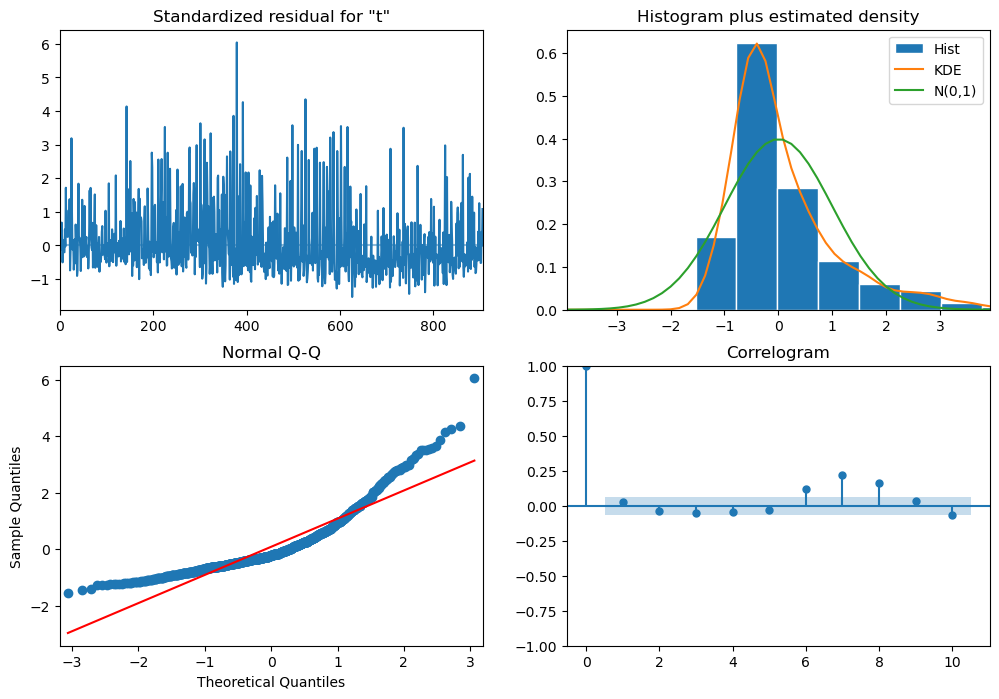

In [17]:
# Diagnóstico del modelo SARIMA
modelo_sarima_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

In [18]:
# Calcular métricas (MAE y RMSE) en el conjunto de entrenamiento
valores_ajustados = modelo_sarima_fit.fittedvalues
valores_reales = datos_base['total_ventas']

mae = mean_absolute_error(valores_reales, valores_ajustados)
rmse = np.sqrt(mean_squared_error(valores_reales, valores_ajustados))

print(f"MAE (Entrenamiento): {mae}")
print(f"RMSE (Entrenamiento): {rmse}")

MAE (Entrenamiento): 2695.9714415192966
RMSE (Entrenamiento): 3746.0300548371747


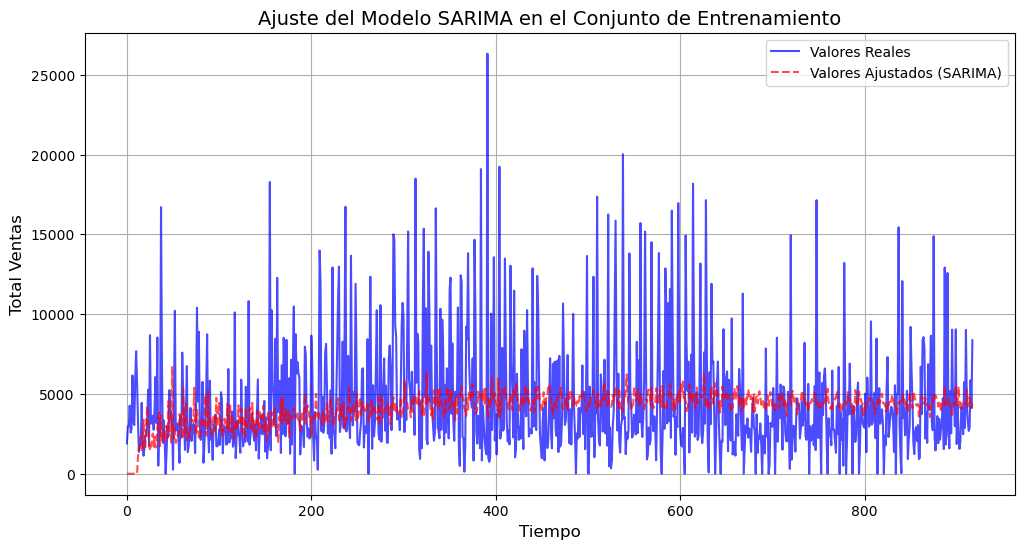

In [19]:
# Graficar los valores reales vs los ajustados
plt.figure(figsize=(12, 6))
plt.plot(datos_base['total_ventas'], label='Valores Reales', color='blue', alpha=0.7)
plt.plot(valores_ajustados, label='Valores Ajustados (SARIMA)', color='red', linestyle='--', alpha=0.7)
plt.title('Ajuste del Modelo SARIMA en el Conjunto de Entrenamiento', fontsize=14)
plt.xlabel('Tiempo', fontsize=12)
plt.ylabel('Total Ventas', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

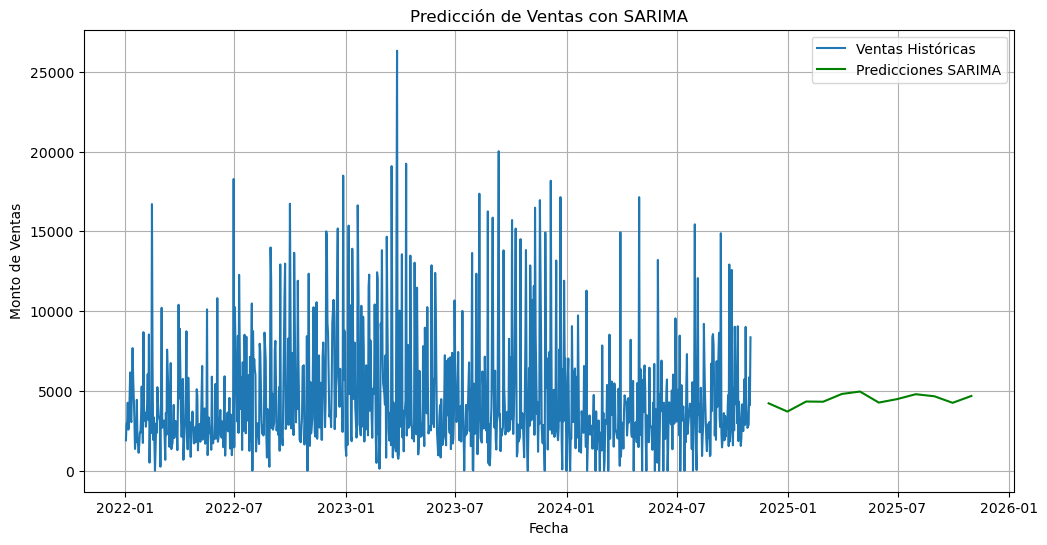

In [20]:
# Predicción de los próximos 12 periodos
predicciones_sarima = modelo_sarima_fit.forecast(steps=12)

# Crear un rango de fechas para las predicciones
import pandas as pd
futuras_fechas = pd.date_range(start=datos_base['fecha'].iloc[-1], periods=13, freq='ME')[1:]

# Visualización de las predicciones
plt.figure(figsize=(12, 6))
plt.plot(datos_base['fecha'], datos_base['total_ventas'], label='Ventas Históricas')
plt.plot(futuras_fechas, predicciones_sarima, label='Predicciones SARIMA', color='green')
plt.title('Predicción de Ventas con SARIMA')
plt.xlabel('Fecha')
plt.ylabel('Monto de Ventas')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Dividir los datos en entrenamiento y prueba
train = datos_base.iloc[:-12]  # Todos menos los últimos 12 meses
test = datos_base.iloc[-12:]  # Últimos 12 meses

# Ajustar el modelo SARIMA con datos de entrenamiento
modelo_sarima_train = SARIMAX(
    train['total_ventas'],
    order=(0, 0, 0),
    seasonal_order=(1, 1, 1, 12)
).fit()

# Predicción en el conjunto de prueba
predicciones_test = modelo_sarima_train.forecast(steps=12)

# Calcular métricas
mae = mean_absolute_error(test['total_ventas'], predicciones_test)
rmse = np.sqrt(mean_squared_error(test['total_ventas'], predicciones_test))

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')


MAE: 1875.6073065076368
RMSE: 2343.447403431802


In [22]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Escalar los datos entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
datos_escalados = scaler.fit_transform(datos_base[['total_ventas']])

# Verificar el escalado
print("Datos escalados:\n", datos_escalados[:5])


Datos escalados:
 [[0.0723342 ]
 [0.11244894]
 [0.11313665]
 [0.16194077]
 [0.0978704 ]]


In [23]:
# Crear datos en formato de ventana deslizante
def crear_secuencias(datos, pasos):
    X, y = [], []
    for i in range(len(datos) - pasos):
        X.append(datos[i:i+pasos, 0])
        y.append(datos[i+pasos, 0])
    return np.array(X), np.array(y)

# Definir pasos hacia atrás
pasos = 30  # Usar 30 días anteriores para predecir el siguiente
X, y = crear_secuencias(datos_escalados, pasos)

# Reshape para LSTM (agregar dimensión de características)
X = X.reshape((X.shape[0], X.shape[1], 1))
print("Forma de X:", X.shape)
print("Forma de y:", y.shape)


Forma de X: (888, 30, 1)
Forma de y: (888,)


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Construir el modelo LSTM
modelo_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(X.shape[1], 1)),
    Dense(1)  # Predicción de un valor
])

# Compilar el modelo
modelo_lstm.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
historial = modelo_lstm.fit(X, y, epochs=50, batch_size=32, verbose=1)


Epoch 1/50


C:\Users\valer\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0326
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0182
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0220
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0165
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0193
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0187
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0182
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0208
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0197
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0182
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0188
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0192
Epoch 13/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0174
Epoch 14/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0193
Epoch 15/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0190
Epoch 16/50
28/28 ━━━━━━━━━━━━

In [25]:
# Predicciones
predicciones = modelo_lstm.predict(X)

# Escalar de regreso a valores originales
predicciones_originales = scaler.inverse_transform(predicciones)

# Convertir y reales a escala original
y_original = scaler.inverse_transform(y.reshape(-1, 1))


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


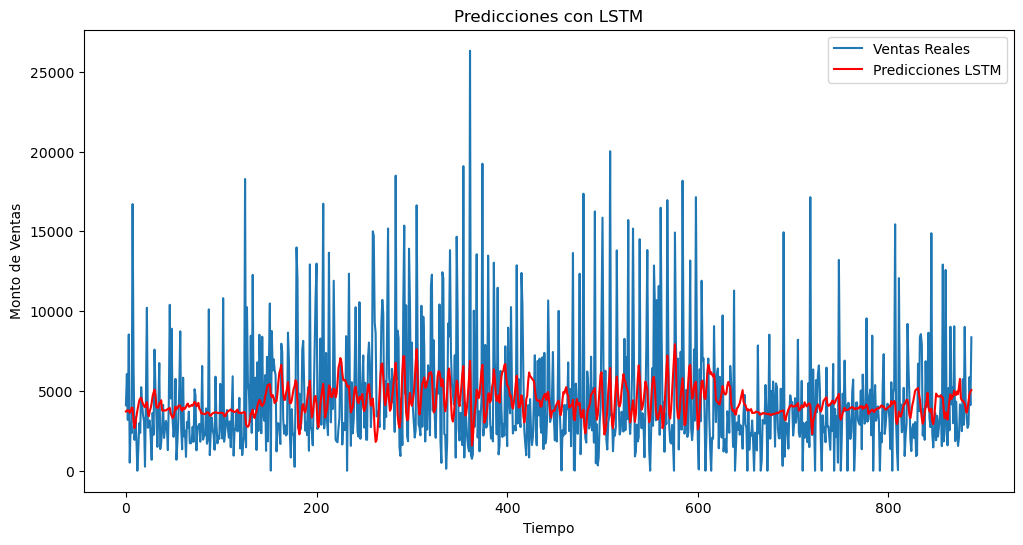

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_original, label='Ventas Reales')
plt.plot(predicciones_originales, label='Predicciones LSTM', color='red')
plt.title('Predicciones con LSTM')
plt.xlabel('Tiempo')
plt.ylabel('Monto de Ventas')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_lstm = mean_absolute_error(y_original, predicciones_originales)
rmse_lstm = np.sqrt(mean_squared_error(y_original, predicciones_originales))

print(f'MAE del modelo LSTM: {mae_lstm}')
print(f'RMSE del modelo LSTM: {rmse_lstm}')

MAE del modelo LSTM: 2523.6387964527025
RMSE del modelo LSTM: 3507.1816067271584


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


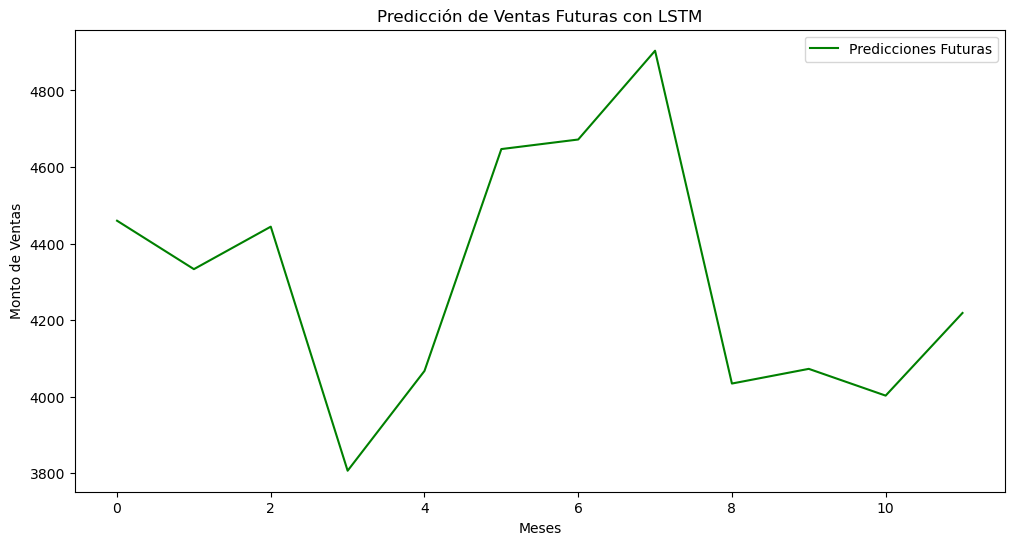

In [28]:
# Crear datos para predicciones futuras
datos_futuros = datos_escalados[-pasos:]
predicciones_futuras = []

for _ in range(12):  # 12 predicciones
    entrada = datos_futuros[-pasos:].reshape((1, pasos, 1))
    prediccion = modelo_lstm.predict(entrada)
    predicciones_futuras.append(prediccion[0, 0])
    datos_futuros = np.append(datos_futuros, prediccion)[-pasos:]

# Escalar de regreso a valores originales
predicciones_futuras_originales = scaler.inverse_transform(np.array(predicciones_futuras).reshape(-1, 1))

# Visualización de predicciones futuras
plt.figure(figsize=(12, 6))
plt.plot(predicciones_futuras_originales, label='Predicciones Futuras', color='green')
plt.title('Predicción de Ventas Futuras con LSTM')
plt.xlabel('Meses')
plt.ylabel('Monto de Ventas')
plt.legend()
plt.show()

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Construir el modelo LSTM profundo
modelo_lstm_profundo = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(X.shape[1], 1)),
    Dropout(0.2),  # Regularización para evitar sobreajuste
    LSTM(50, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dense(1)  # Predicción de un valor
])

# Compilar el modelo
modelo_lstm_profundo.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
historial_profundo = modelo_lstm_profundo.fit(X, y, epochs=100, batch_size=32, verbose=1)


Epoch 1/100


C:\Users\valer\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0368
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0190
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0177
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0189
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0207
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0167
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0199
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0191
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0169
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0176
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0186
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0213
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0188
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0184
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0169
E

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
MAE del modelo LSTM profundo: 2455.84889868384
RMSE del modelo LSTM profundo: 3516.907492440842


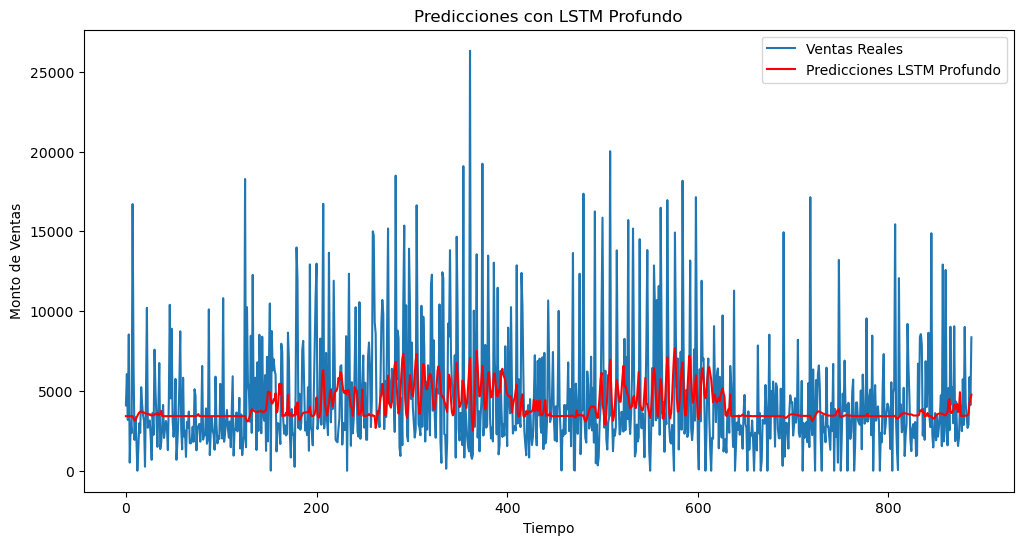

In [30]:
# Predicciones en el conjunto de entrenamiento
predicciones_profundas = modelo_lstm_profundo.predict(X)

# Escalar de regreso a valores originales
predicciones_profundas_originales = scaler.inverse_transform(predicciones_profundas)
y_original = scaler.inverse_transform(y.reshape(-1, 1))

# Calcular métricas
mae_profundo = mean_absolute_error(y_original, predicciones_profundas_originales)
rmse_profundo = np.sqrt(mean_squared_error(y_original, predicciones_profundas_originales))

print(f'MAE del modelo LSTM profundo: {mae_profundo}')
print(f'RMSE del modelo LSTM profundo: {rmse_profundo}')

# Visualizar predicciones frente a valores reales
plt.figure(figsize=(12, 6))
plt.plot(y_original, label='Ventas Reales')
plt.plot(predicciones_profundas_originales, label='Predicciones LSTM Profundo', color='red')
plt.title('Predicciones con LSTM Profundo')
plt.xlabel('Tiempo')
plt.ylabel('Monto de Ventas')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


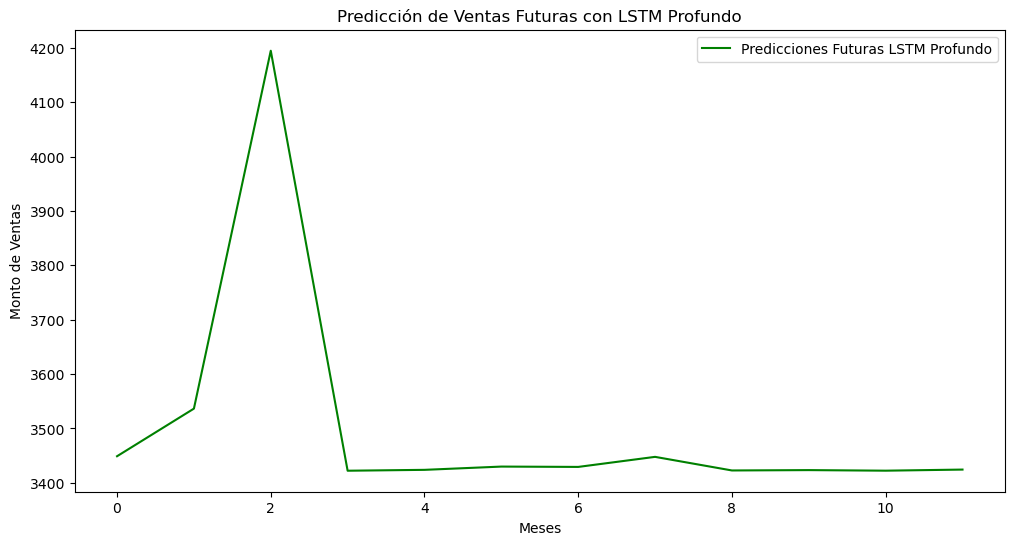

In [31]:
# Crear datos para predicciones futuras
datos_futuros_profundos = datos_escalados[-pasos:]
predicciones_futuras_profundas = []

for _ in range(12):  # 12 predicciones
    entrada = datos_futuros_profundos[-pasos:].reshape((1, pasos, 1))
    prediccion = modelo_lstm_profundo.predict(entrada)
    predicciones_futuras_profundas.append(prediccion[0, 0])
    datos_futuros_profundos = np.append(datos_futuros_profundos, prediccion)[-pasos:]

# Escalar de regreso a valores originales
predicciones_futuras_profundas_originales = scaler.inverse_transform(np.array(predicciones_futuras_profundas).reshape(-1, 1))

# Visualización de predicciones futuras
plt.figure(figsize=(12, 6))
plt.plot(predicciones_futuras_profundas_originales, label='Predicciones Futuras LSTM Profundo', color='green')
plt.title('Predicción de Ventas Futuras con LSTM Profundo')
plt.xlabel('Meses')
plt.ylabel('Monto de Ventas')
plt.legend()
plt.show()


In [32]:
# Crear datos en formato de ventana deslizante con 60 pasos
pasos_opt = 60  # Ventana de 60 días
X_opt, y_opt = crear_secuencias(datos_escalados, pasos_opt)

# Reshape para LSTM
X_opt = X_opt.reshape((X_opt.shape[0], X_opt.shape[1], 1))
print("Forma de X optimizado:", X_opt.shape)
print("Forma de y optimizado:", y_opt.shape)


Forma de X optimizado: (858, 60, 1)
Forma de y optimizado: (858,)


In [33]:
from tensorflow.keras.layers import BatchNormalization

# Modelo optimizado
modelo_lstm_opt = Sequential([
    LSTM(150, activation='relu', return_sequences=True, input_shape=(X_opt.shape[1], 1)),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(100, activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(50, activation='relu'),
    Dense(1)
])

# Compilación y entrenamiento
modelo_lstm_opt.compile(optimizer='adam', loss='mse')

# Entrenamiento con más épocas
historial_opt = modelo_lstm_opt.fit(X_opt, y_opt, epochs=150, batch_size=32, verbose=1)


C:\Users\valer\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.0244
Epoch 2/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0200
Epoch 3/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0180
Epoch 4/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0204
Epoch 5/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0204
Epoch 6/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0177
Epoch 7/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0198
Epoch 8/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0187
Epoch 9/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0182
Epoch 10/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0191
Epoch 11/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0163
Epoch 12/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0191
Epoch 13/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0179
Epoch 14/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0184
Epoch 15/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - lo

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
MAE del modelo LSTM optimizado: 2259.759850425454
RMSE del modelo LSTM optimizado: 3222.590170895849


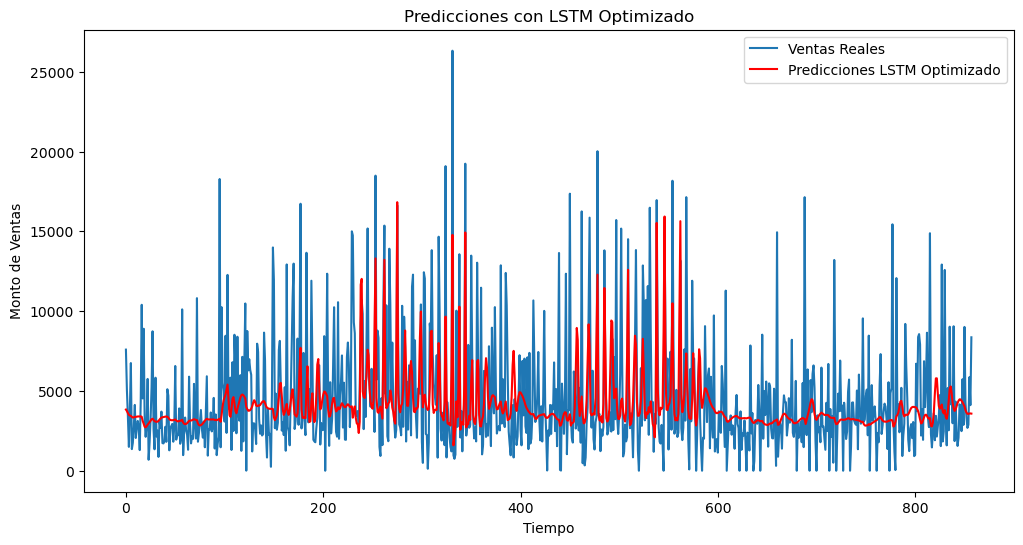

In [34]:
# Predicciones en el conjunto de entrenamiento optimizado
predicciones_opt = modelo_lstm_opt.predict(X_opt)

# Escalar de regreso a valores originales
predicciones_opt_originales = scaler.inverse_transform(predicciones_opt)
y_opt_original = scaler.inverse_transform(y_opt.reshape(-1, 1))

# Calcular métricas
mae_opt = mean_absolute_error(y_opt_original, predicciones_opt_originales)
rmse_opt = np.sqrt(mean_squared_error(y_opt_original, predicciones_opt_originales))

print(f'MAE del modelo LSTM optimizado: {mae_opt}')
print(f'RMSE del modelo LSTM optimizado: {rmse_opt}')

# Visualizar predicciones frente a valores reales
plt.figure(figsize=(12, 6))
plt.plot(y_opt_original, label='Ventas Reales')
plt.plot(predicciones_opt_originales, label='Predicciones LSTM Optimizado', color='red')
plt.title('Predicciones con LSTM Optimizado')
plt.xlabel('Tiempo')
plt.ylabel('Monto de Ventas')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


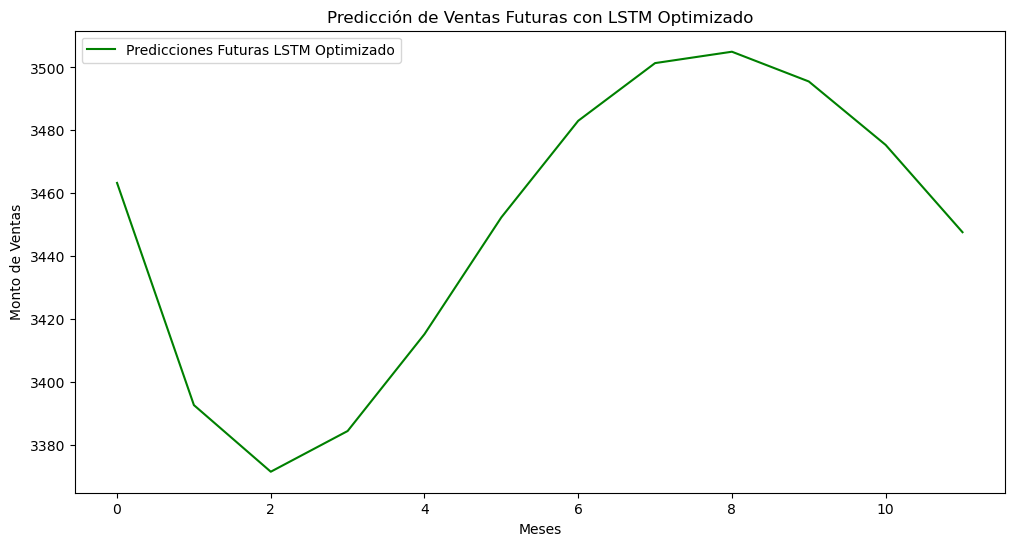

In [35]:
# Crear datos para predicciones futuras optimizadas
datos_futuros_opt = datos_escalados[-pasos_opt:]
predicciones_futuras_opt = []

for _ in range(12):  # 12 predicciones
    entrada = datos_futuros_opt[-pasos_opt:].reshape((1, pasos_opt, 1))
    prediccion = modelo_lstm_opt.predict(entrada)
    predicciones_futuras_opt.append(prediccion[0, 0])
    datos_futuros_opt = np.append(datos_futuros_opt, prediccion)[-pasos_opt:]

# Escalar de regreso a valores originales
predicciones_futuras_opt_originales = scaler.inverse_transform(np.array(predicciones_futuras_opt).reshape(-1, 1))

# Visualización de predicciones futuras
plt.figure(figsize=(12, 6))
plt.plot(predicciones_futuras_opt_originales, label='Predicciones Futuras LSTM Optimizado', color='green')
plt.title('Predicción de Ventas Futuras con LSTM Optimizado')
plt.xlabel('Meses')
plt.ylabel('Monto de Ventas')
plt.legend()
plt.show()


In [36]:
# Asegurarnos de que el índice del DataFrame esté basado en fechas
datos_base['fecha'] = pd.to_datetime(datos_base['fecha'], errors='coerce')  # Convertir columna de fechas
datos_base = datos_base.set_index('fecha')  # Establecer la columna 'Fecha' como índice

# Verificar si hay valores no válidos en el índice
print("Valores no válidos (NaT):", datos_base.index.isnull().sum())

# Eliminar filas con fechas no válidas
datos_base = datos_base[~datos_base.index.isnull()]

# Confirmar la corrección
print("Índice corregido:", datos_base.index)


Valores no válidos (NaT): 0
Índice corregido: DatetimeIndex(['2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06',
               '2022-01-07', '2022-01-08', '2022-01-10', '2022-01-11',
               '2022-01-12', '2022-01-13',
               ...
               '2024-10-21', '2024-10-22', '2024-10-23', '2024-10-24',
               '2024-10-25', '2024-10-26', '2024-10-28', '2024-10-29',
               '2024-10-30', '2024-10-31'],
              dtype='datetime64[ns]', name='fecha', length=918, freq=None)


In [37]:
import pandas as pd

# Crear un DataFrame con los valores reales, predicciones y error
tabla_predicciones = pd.DataFrame({
    'Fecha': datos_base.index[-len(y_opt_original):],  # Fechas de las predicciones
    'Ventas Reales': y_opt_original.flatten(),         # Valores reales
    'Predicciones': predicciones_opt_originales.flatten(),  # Predicciones
    'Error Absoluto': abs(y_opt_original.flatten() - predicciones_opt_originales.flatten())  # Error absoluto
})

# Mostrar las primeras filas
tabla_predicciones.head()



,Fecha,Ventas Reales,Predicciones,Error Absoluto
0,2022-03-12,7588.9,3834.661865,3754.238135
1,2022-03-14,5037.4,3735.812500,1301.587500
2,2022-03-15,3379.3,3607.752197,228.452197
3,2022-03-16,1494.5,3502.655762,2008.155762
4,2022-03-17,3822.4,3455.560547,366.839453


In [38]:
# Crear un DataFrame para predicciones futuras
tabla_predicciones_futuras = pd.DataFrame({
    'Mes': [f'Mes {i+1}' for i in range(12)],  # Etiquetas para los meses futuros
    'Predicciones Futuras': predicciones_futuras_opt_originales.flatten()  # Predicciones futuras
})

# Mostrar las primeras filas
print(tabla_predicciones_futuras)

# Guardar en un archivo Excel
tabla_predicciones_futuras.to_excel('tabla_predicciones_futuras.xlsx', index=False)


       Mes  Predicciones Futuras
0    Mes 1           3463.253906
1    Mes 2           3392.570801
2    Mes 3           3371.379395
3    Mes 4           3384.327393
4    Mes 5           3415.147949
5    Mes 6           3452.299072
6    Mes 7           3483.011719
7    Mes 8           3501.364502
8    Mes 9           3504.984619
9   Mes 10           3495.526367
10  Mes 11           3475.339111
11  Mes 12           3447.570557


In [39]:
# Mostrar tablas en Jupyter Notebook
from IPython.display import display

print("Tabla de predicciones históricas:")
display(tabla_predicciones)

print("\nTabla de predicciones futuras:")
display(tabla_predicciones_futuras)


Tabla de predicciones históricas:


,Fecha,Ventas Reales,Predicciones,Error Absoluto
0,2022-03-12,7588.9,3834.661865,3754.238135
1,2022-03-14,5037.4,3735.812500,1301.587500
2,2022-03-15,3379.3,3607.752197,228.452197
3,2022-03-16,1494.5,3502.655762,2008.155762
4,2022-03-17,3822.4,3455.560547,366.839453
...,...,...,...,...
853,2024-10-26,2683.0,3568.538574,885.538574
854,2024-10-28,2882.5,3559.245605,676.745605
855,2024-10-29,5862.5,3587.821045,2274.678955
856,2024-10-30,4109.5,3588.620850,520.879150



Tabla de predicciones futuras:


,Mes,Predicciones Futuras
0,Mes 1,3463.253906
1,Mes 2,3392.570801
2,Mes 3,3371.379395
3,Mes 4,3384.327393
4,Mes 5,3415.147949
5,Mes 6,3452.299072
6,Mes 7,3483.011719
7,Mes 8,3501.364502
8,Mes 9,3504.984619
9,Mes 10,3495.526367


In [40]:
# Crear un DataFrame para predicciones históricas
tabla_predicciones_historicas = pd.DataFrame({
    'Fecha': datos_base.index[-len(y_opt_original):],  # Fechas reales del conjunto de datos
    'Ventas Reales': y_opt_original.flatten(),         # Valores reales
    'Predicciones': predicciones_opt_originales.flatten(),  # Predicciones
    'Error Absoluto': abs(y_opt_original.flatten() - predicciones_opt_originales.flatten())  # Error absoluto
})

# Mostrar las primeras filas
print(tabla_predicciones_historicas.head())

# Guardar en Excel o CSV
tabla_predicciones_historicas.to_excel('tabla_predicciones_historicas.xlsx', index=False)


       Fecha  Ventas Reales  Predicciones  Error Absoluto
0 2022-03-12         7588.9   3834.661865     3754.238135
1 2022-03-14         5037.4   3735.812500     1301.587500
2 2022-03-15         3379.3   3607.752197      228.452197
3 2022-03-16         1494.5   3502.655762     2008.155762
4 2022-03-17         3822.4   3455.560547      366.839453


In [41]:
# Generar rango de fechas futuras
ultima_fecha = datos_base.index[-1]  # Última fecha del conjunto de datos
fechas_futuras = pd.date_range(start=ultima_fecha + pd.Timedelta(days=1), periods=12, freq='ME')

# Crear un DataFrame para predicciones futuras
tabla_predicciones_futuras = pd.DataFrame({
    'Fecha': fechas_futuras,  # Fechas futuras generadas
    'Predicciones Futuras': predicciones_futuras_opt_originales.flatten()  # Predicciones futuras
})

# Mostrar las primeras filas
print(tabla_predicciones_futuras)

# Guardar en Excel o CSV
tabla_predicciones_futuras.to_excel('tabla_predicciones_futuras.xlsx', index=False)


        Fecha  Predicciones Futuras
0  2024-11-30           3463.253906
1  2024-12-31           3392.570801
2  2025-01-31           3371.379395
3  2025-02-28           3384.327393
4  2025-03-31           3415.147949
5  2025-04-30           3452.299072
6  2025-05-31           3483.011719
7  2025-06-30           3501.364502
8  2025-07-31           3504.984619
9  2025-08-31           3495.526367
10 2025-09-30           3475.339111
11 2025-10-31           3447.570557
